# Credit Risk Analysis Using Machine Learning

# Problem Statement

Approving loans without proper scientific evaluation increases the risk of default. This can lead to bankruptcy of lending agencies and consequently the destabilization of the banking system. This is what happened in the 2008 financial crisis which affected the world economy adversely. Three components decide the amount of loss that a firm faces as a result of loan default:

* Probability of Default (PD)
* Exposure at Default (EAD)
* Loss given Default (LGD)
The expected loss (E-Loss) is the simple product of these three quantities:

ELoss=PD⋅EAD⋅LGD

Our focus here is on the Probability of Default (PD). Here, we will look at the example of German Credit data which is taken from the Kaggle database.

# Data Understanding 

As a first step, we look at the data. Numpy and Pandas libraries in python are excellent tools for data exploration. For the data visualization we mainly use the matplotlib and the seaborn libraries. We import these libraries into our workspace.

### Importing Libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as py 
py.init_notebook_mode(connected=True)                  
import plotly.graph_objs as go                         
import plotly.subplots as sp                            
from collections import Counter                        
import plotly.figure_factory as ff
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, silhouette_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier



In [7]:
df = pd.read_csv("german_credit_data.csv", index_col=False)
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


The first eight columns are the feature variables and the last column (Risk) is the target variable, which we want to classify as “good” or “bad”. The purpose of the Machine Learning model is to capture the relations between the features and the target variables and predict the credit risk for future applicants.

# Exploratory Data Analysis

Are females more likely to default or is it less risky to lend money to rich people? These kinds of questions can qualitatively be answered by visualizing the data. We create a sub-table for each feature variable in question.

In [9]:
df_sm = df.copy()

In [10]:
#cross table for the 'Sex' feature
cross_sex = pd.crosstab(df['Risk'], df['Sex']).apply(lambda x: x/x.sum() * 100)
decimals = pd.Series([2,2], index=['Male', 'Female'])
cross_sex = cross_sex.round(decimals)
cross_sex_transposed = cross_sex.T
cross_sex_transposed.style.background_gradient(cmap='Blues')

Risk,bad,good
Sex,,
female,35.161290,64.838710
male,27.681159,72.318841


The values presented here are in percentage. It seems, the feature “Sex” contains valuable information for the classification. In this data set, females are slightly more likely to default (however, this cannot be used as a general conclusion). We can better perceive it from the graph below

### Age and Sex Distributons

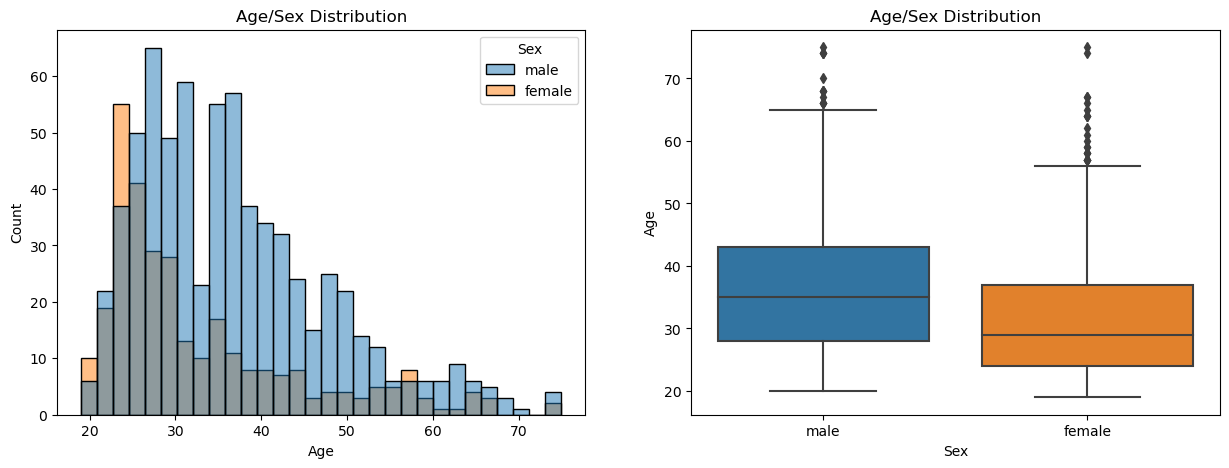

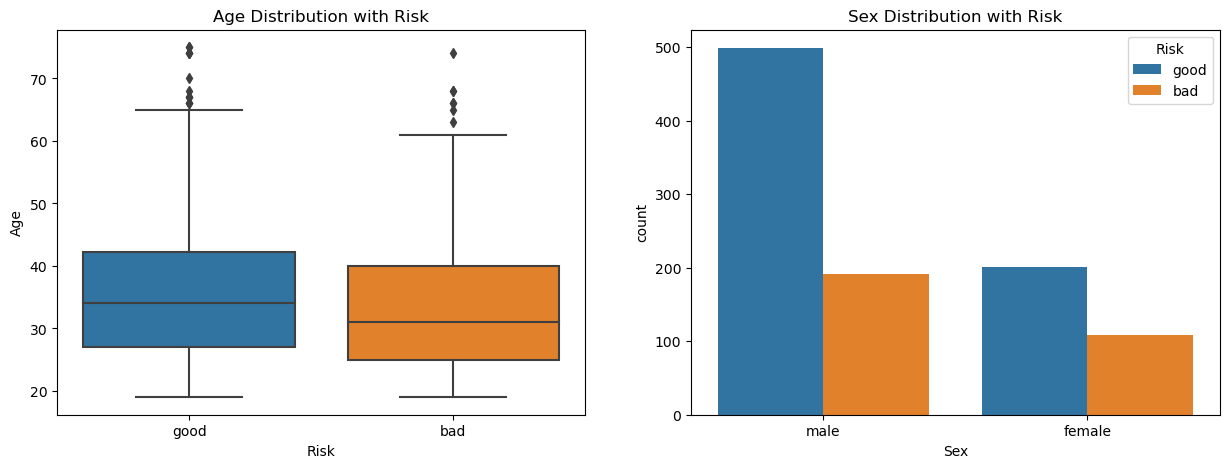

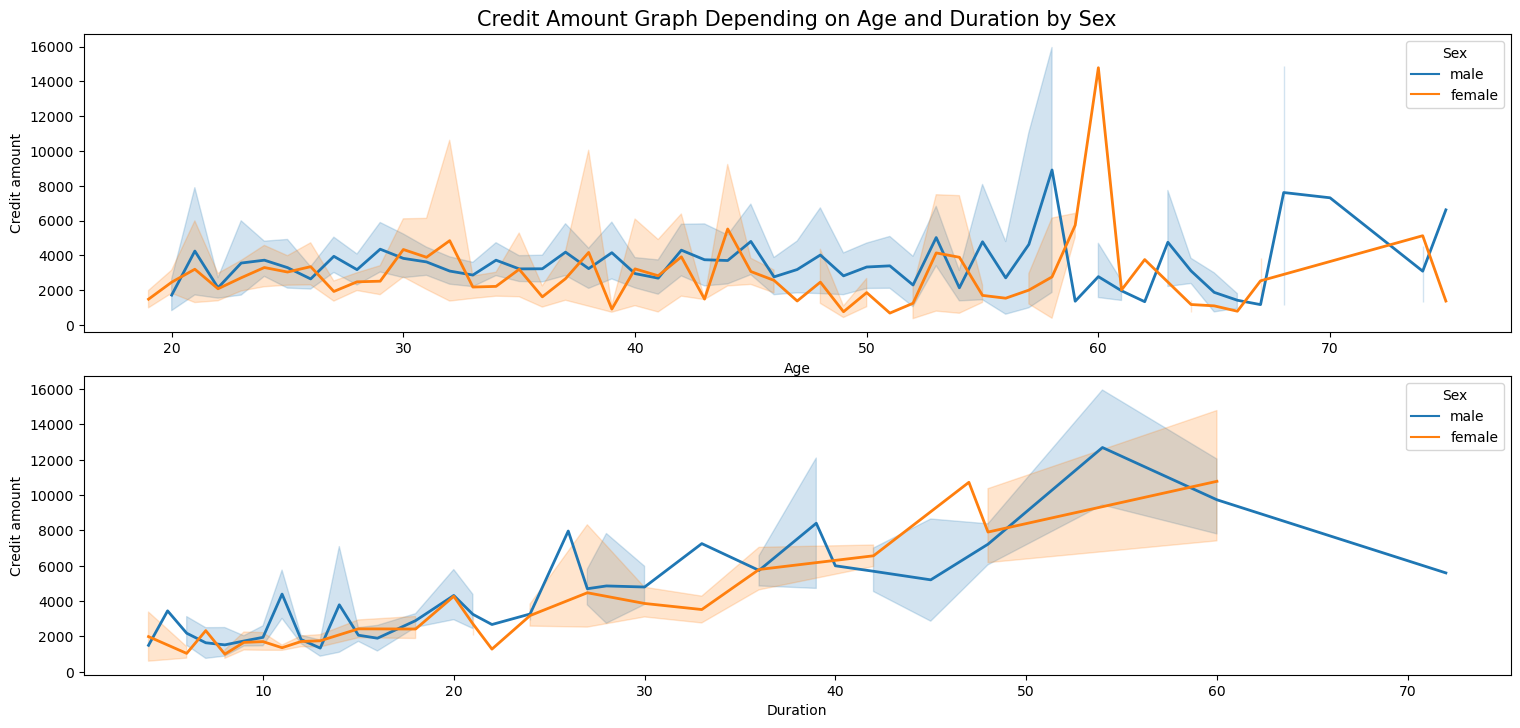

In [12]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(df, x='Age', bins=30, hue="Sex", ax=ax[0]).set_title("Age/Sex Distribution");
sns.boxplot(data=df, x="Sex", y="Age", ax=ax[1]).set_title("Age/Sex Distribution");

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=df, x='Risk', y='Age', ax=ax[0]).set_title("Age Distribution with Risk");
sns.countplot(data=df, x="Sex", hue="Risk", ax=ax[1]).set_title("Sex Distribution with Risk");

fig, ax = plt.subplots(2,1,figsize=(15,7))
plt.tight_layout()
sns.lineplot(data=df, x='Age', y='Credit amount', hue='Sex', lw=2, ax=ax[0]).set_title("Credit Amount Graph Depending on Age and Duration by Sex", fontsize=15);
sns.lineplot(data=df, x='Duration', y='Credit amount', hue='Sex', lw=2, ax=ax[1]);

* Looking at the chart, the highest credit amount was reached at the age of 60 and around.
* Looking at the graph, the highest loan amounts between 50-60 duration have been reached.

In [15]:
df_good = df.loc[df["Risk"] == 'good']['Age'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Age'].values.tolist()
df_age = df['Age'].values.tolist()

#First plot
trace0 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit",
    marker=dict(
        color='#85ead9'
    )
)
#Second plot
trace1 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit",
    marker=dict(
        color='#6f2cea'
    )
)
#Third plot
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age",
    marker=dict(
        color='#f392f4'
    )
)

#Creating the grid
fig = sp.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Good','Bad', 'General Distribuition'))

#setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(showlegend=True, title='Age Distribuition', bargap=0.05)
py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

In [16]:
#Let's look the Credit Amount column
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
df_sm["Age_cat"] = pd.cut(df_sm.Age, interval, labels=cats)


df_good = df_sm[df_sm["Risk"] == 'good']
df_bad = df_sm[df_sm["Risk"] == 'bad']

In [17]:
trace0 = go.Box(
    y=df_good["Credit amount"],
    x=df_good["Age_cat"],
    name='Good credit',
    marker=dict(
        color='#50f466'
    )
)

trace1 = go.Box(
    y=df_bad['Credit amount'],
    x=df_bad['Age_cat'],
    name='Bad credit',
    marker=dict(
        color='#b2014e'
    )
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount (US Dollar)',
        zeroline=False
    ),
    xaxis=dict(
        title='Age Categorical'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

In [18]:
#First plot
trace0 = go.Bar(
                x = df[df["Risk"]== 'good']["Housing"].value_counts().index.values,
                y = df[df["Risk"]== 'good']["Housing"].value_counts().values,
                name='Good credit',
                marker=dict(
                color='#a4e23f'
                    )
                )

#Second plot
trace1 = go.Bar(
                x = df[df["Risk"]== 'bad']["Housing"].value_counts().index.values,
                y = df[df["Risk"]== 'bad']["Housing"].value_counts().values,
                name="Bad Credit",
                marker=dict(
                color='#b2014e'
                    )
                )

data = [trace0, trace1]

layout = go.Layout(title='Housing Distribuition')


fig = go.Figure(data=data, layout=layout)
fig.data[0].marker.line.width = 4
fig.data[0].marker.line.color = "black"
fig.data[1].marker.line.width = 4
fig.data[1].marker.line.color = "black"

py.iplot(fig, filename='Housing-Grouped')
plt.show()


In [19]:
#First plot
trace0 = go.Bar(
                x = df_sm[df_sm["Risk"]== 'good']["Job"].value_counts().index.values,
                y = df_sm[df_sm["Risk"]== 'good']["Job"].value_counts().values,
                name='Good credit',
                marker=dict(
                color='#a4e23f'
                    )
                )

#Second plot
trace1 = go.Bar(
                x = df_sm[df_sm["Risk"]== 'bad']["Job"].value_counts().index.values,
                y = df_sm[df_sm["Risk"]== 'bad']["Job"].value_counts().values,
                name="Bad Credit",
                marker=dict(
                color='#b2014e'
                    )
                )

data = [trace0, trace1]

layout = go.Layout(title='Job Distribuitio')


fig = go.Figure(data=data, layout=layout)
fig.data[0].marker.line.width = 4
fig.data[0].marker.line.color = "black"
fig.data[1].marker.line.width = 4
fig.data[1].marker.line.color = "black"

py.iplot(fig, filename='Job-Grouped')
plt.show()


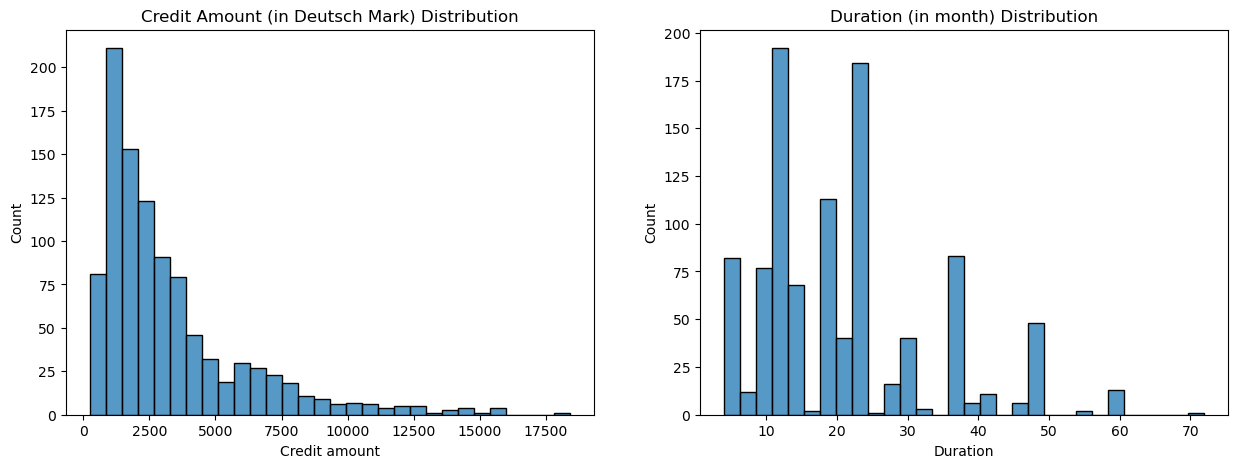

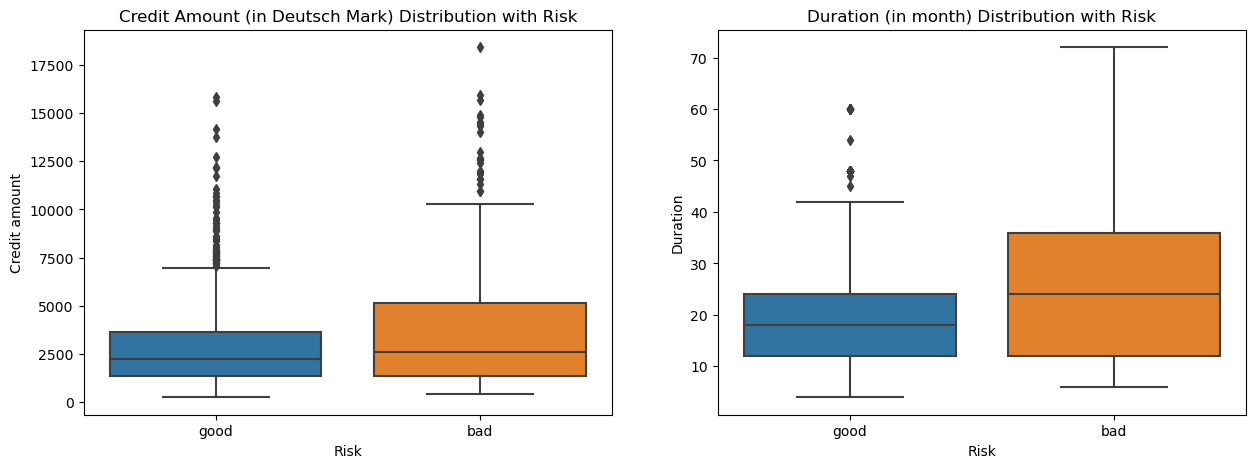

In [20]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(df_sm, x='Credit amount', bins=30, ax=ax[0]).set_title("Credit Amount (in Deutsch Mark) Distribution");
sns.histplot(df_sm, x='Duration', bins=30, ax=ax[1]).set_title("Duration (in month) Distribution");

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=df_sm, x='Risk', y='Credit amount', ax=ax[0]).set_title("Credit Amount (in Deutsch Mark) Distribution with Risk");
sns.boxplot(data=df_sm, x='Risk', y='Duration', ax=ax[1]).set_title("Duration (in month) Distribution with Risk");

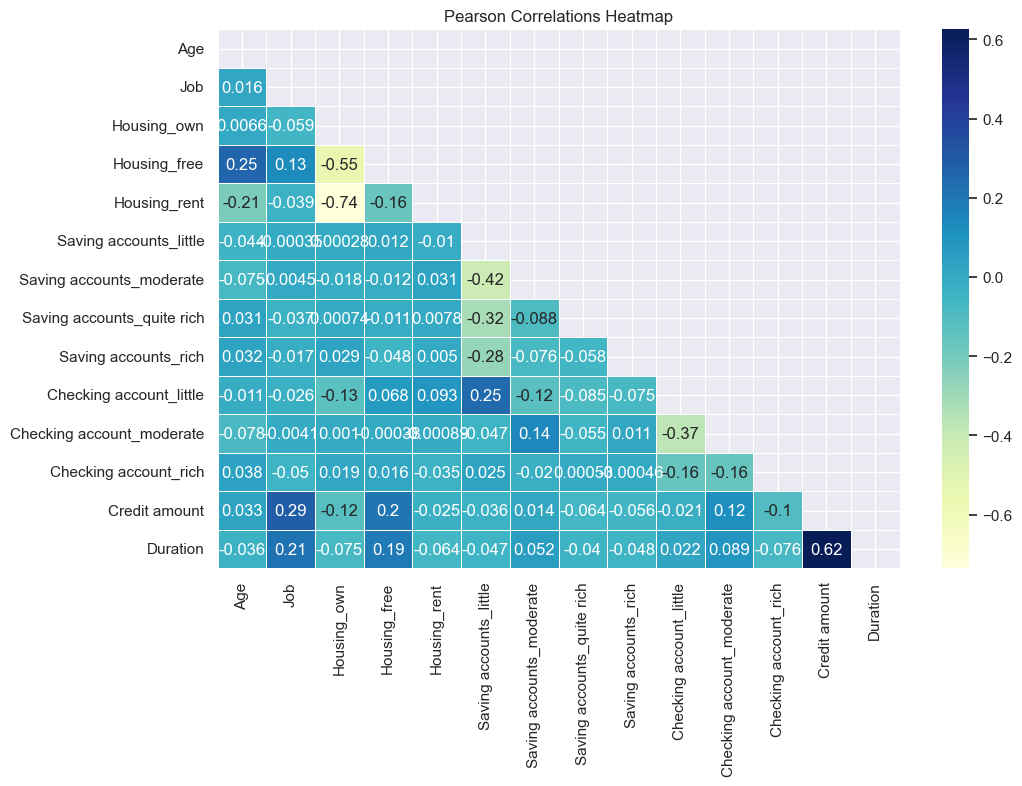

In [24]:
import pandas as pd

# Assuming 'df_sm' is your DataFrame
df_sm_encoded = pd.get_dummies(df_sm, columns=['Housing', 'Saving accounts', 'Checking account'])

# Now, you can calculate the correlation
corr = df_sm_encoded[['Age', 'Job', 'Housing_own', 'Housing_free', 'Housing_rent', 'Saving accounts_little', 'Saving accounts_moderate', 'Saving accounts_quite rich', 'Saving accounts_rich', 'Checking account_little', 'Checking account_moderate', 'Checking account_rich', 'Credit amount', 'Duration']].corr()

#corr = df_sm[['Age', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration']].corr()
sns.set(rc={'figure.figsize':(11,7)})
sns.heatmap(corr,linewidths=.5, annot=True, cmap="YlGnBu",mask=np.triu(np.ones_like(corr, dtype=bool)))\
    .set_title("Pearson Correlations Heatmap");

## Handle Missing Values

Most Machine Learning models cannot handle missing values within the feature space, or these can adversely diminish the prediction power of the model. Therefore, we need to check for them

In [25]:
df.isnull().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [29]:
###Explore the Values of Text Columns:

In [30]:
cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']
for col in cols:
    line = "**" + col + ":** "
    for v in df[col].unique():
        line = line + str(v) + ", "
    print(line)

**Sex:** male, female, 
**Housing:** own, free, rent, 
**Saving accounts:** nan, little, quite rich, rich, moderate, 
**Checking account:** little, moderate, nan, rich, 
**Purpose:** radio/TV, education, furniture/equipment, car, business, domestic appliances, repairs, vacation/others, 
**Risk:** good, bad, 


From above exploration:

* Columns "Housing", "Saving accounts" and "Checking accounts" are Ordinal data.
* Columns "Sex", "Purpose" and "Risk" are Categorical data.

In [31]:
# label encode account quality and fill NaN with 0
def SC_LabelEncoder(text):
    if text == "little":
        return 1
    elif text == "moderate":
        return 2
    elif text == "quite rich":
        return 3
    elif text == "rich":
        return 4
    else:
        return 0

df["Saving accounts"] = df["Saving accounts"].apply(SC_LabelEncoder)
df["Checking account"] = df["Checking account"].apply(SC_LabelEncoder)

In [32]:
# label encode account quality and fill NaN with 0
def H_LabelEncoder(text):
    if text == "free":
        return 0
    elif text == "rent":
        return 1
    elif text == "own":
        return 2

df["Housing"] = df["Housing"].apply(H_LabelEncoder)

# Data Pre-processing For Discrete Categorical Columns
From the raw data we saw that the target variable risk is categorical (‘good’ or ‘bad’). Therefore, this is a classification problem. There are many classification algorithms in the literature with the Random Forest classifier being considered one of the standard classifiers.



In [33]:
# use LabelEncoder() to encode other categorical columns:
from sklearn.preprocessing import LabelEncoder
for col in ["Sex", "Purpose", "Risk", "Age"]:
    le = LabelEncoder()
    le.fit(df[col])
    df[col] = le.transform(df[col])
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,48,1,2,2,0,1,1169,6,5,1
1,1,3,0,2,2,1,2,5951,48,5,0
2,2,30,1,1,2,1,0,2096,12,3,1
3,3,26,1,2,0,1,1,7882,42,4,1
4,4,34,1,2,0,1,1,4870,24,1,0


Now that we have all the features and target variable in the numerical form, we can finally train and fit our model. For that we should first split our data into a train set and a test set. The train set would be used to capture the relations between the features and the target variables while the test set will be used to verify the performance of the model.

# Build Model

### Clustering

#### Start with applying Elbow Method.

In [34]:
cdf = df.drop("Risk", axis=1)

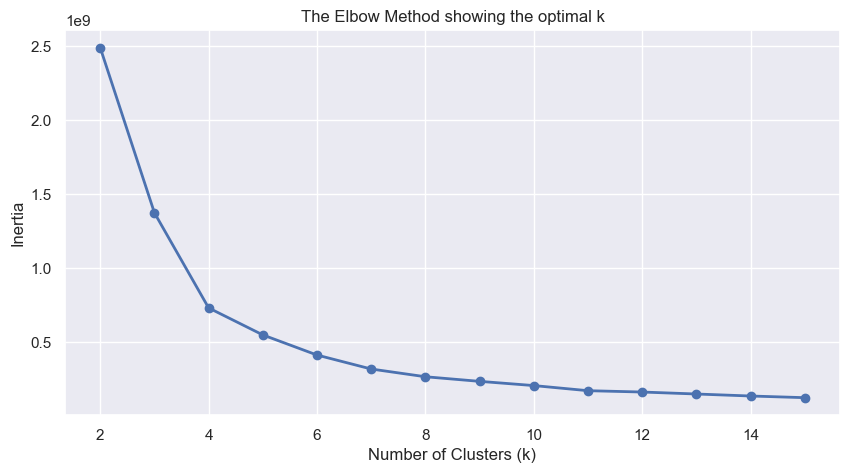

In [37]:
inertias = []

for i in range(2, 16):
    kmeans = KMeans(n_clusters=i, n_init=n_init, random_state=0).fit(cdf)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.title('The Elbow Method showing the optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.plot(np.arange(2, 16), inertias, marker='o', lw=2)
plt.show()

**Analysis:** The "elbow" in above chart is indicated  at 4. The number of clusters chosen should therefore be 4. 
#### With 4 Clusters:

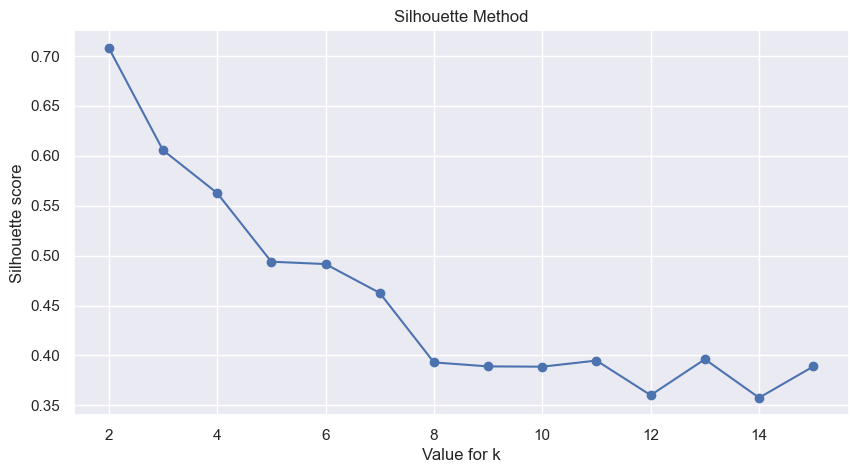

In [39]:
k = range(2,16)
score=[]
for n_cluster in k:
    kmeans = KMeans(n_clusters=n_cluster, n_init=n_init).fit(cdf)
    score.append(silhouette_score(cdf,kmeans.labels_))
plt.figure(figsize=(10,5))
plt.plot(k, score, 'o-')
plt.xlabel("Value for k")
plt.ylabel("Silhouette score")
plt.title('Silhouette Method')
plt.show()

Use K-means to cluster people in the records into 4 group and check if the result closed to given two risk groups

In [41]:
km = KMeans(n_clusters=4, random_state=0, n_init = n_init)
clusters = km.fit_predict(cdf)

In [43]:
acc = max((sum(clusters == df["Risk"]) / len(df)), (sum(clusters != df["Risk"]) / len(df)))
print("The accuracy rate of 4-Means clustering is " + str(acc))

The accuracy rate of 4-Means clustering is 0.77


C:\Users\Giacomo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



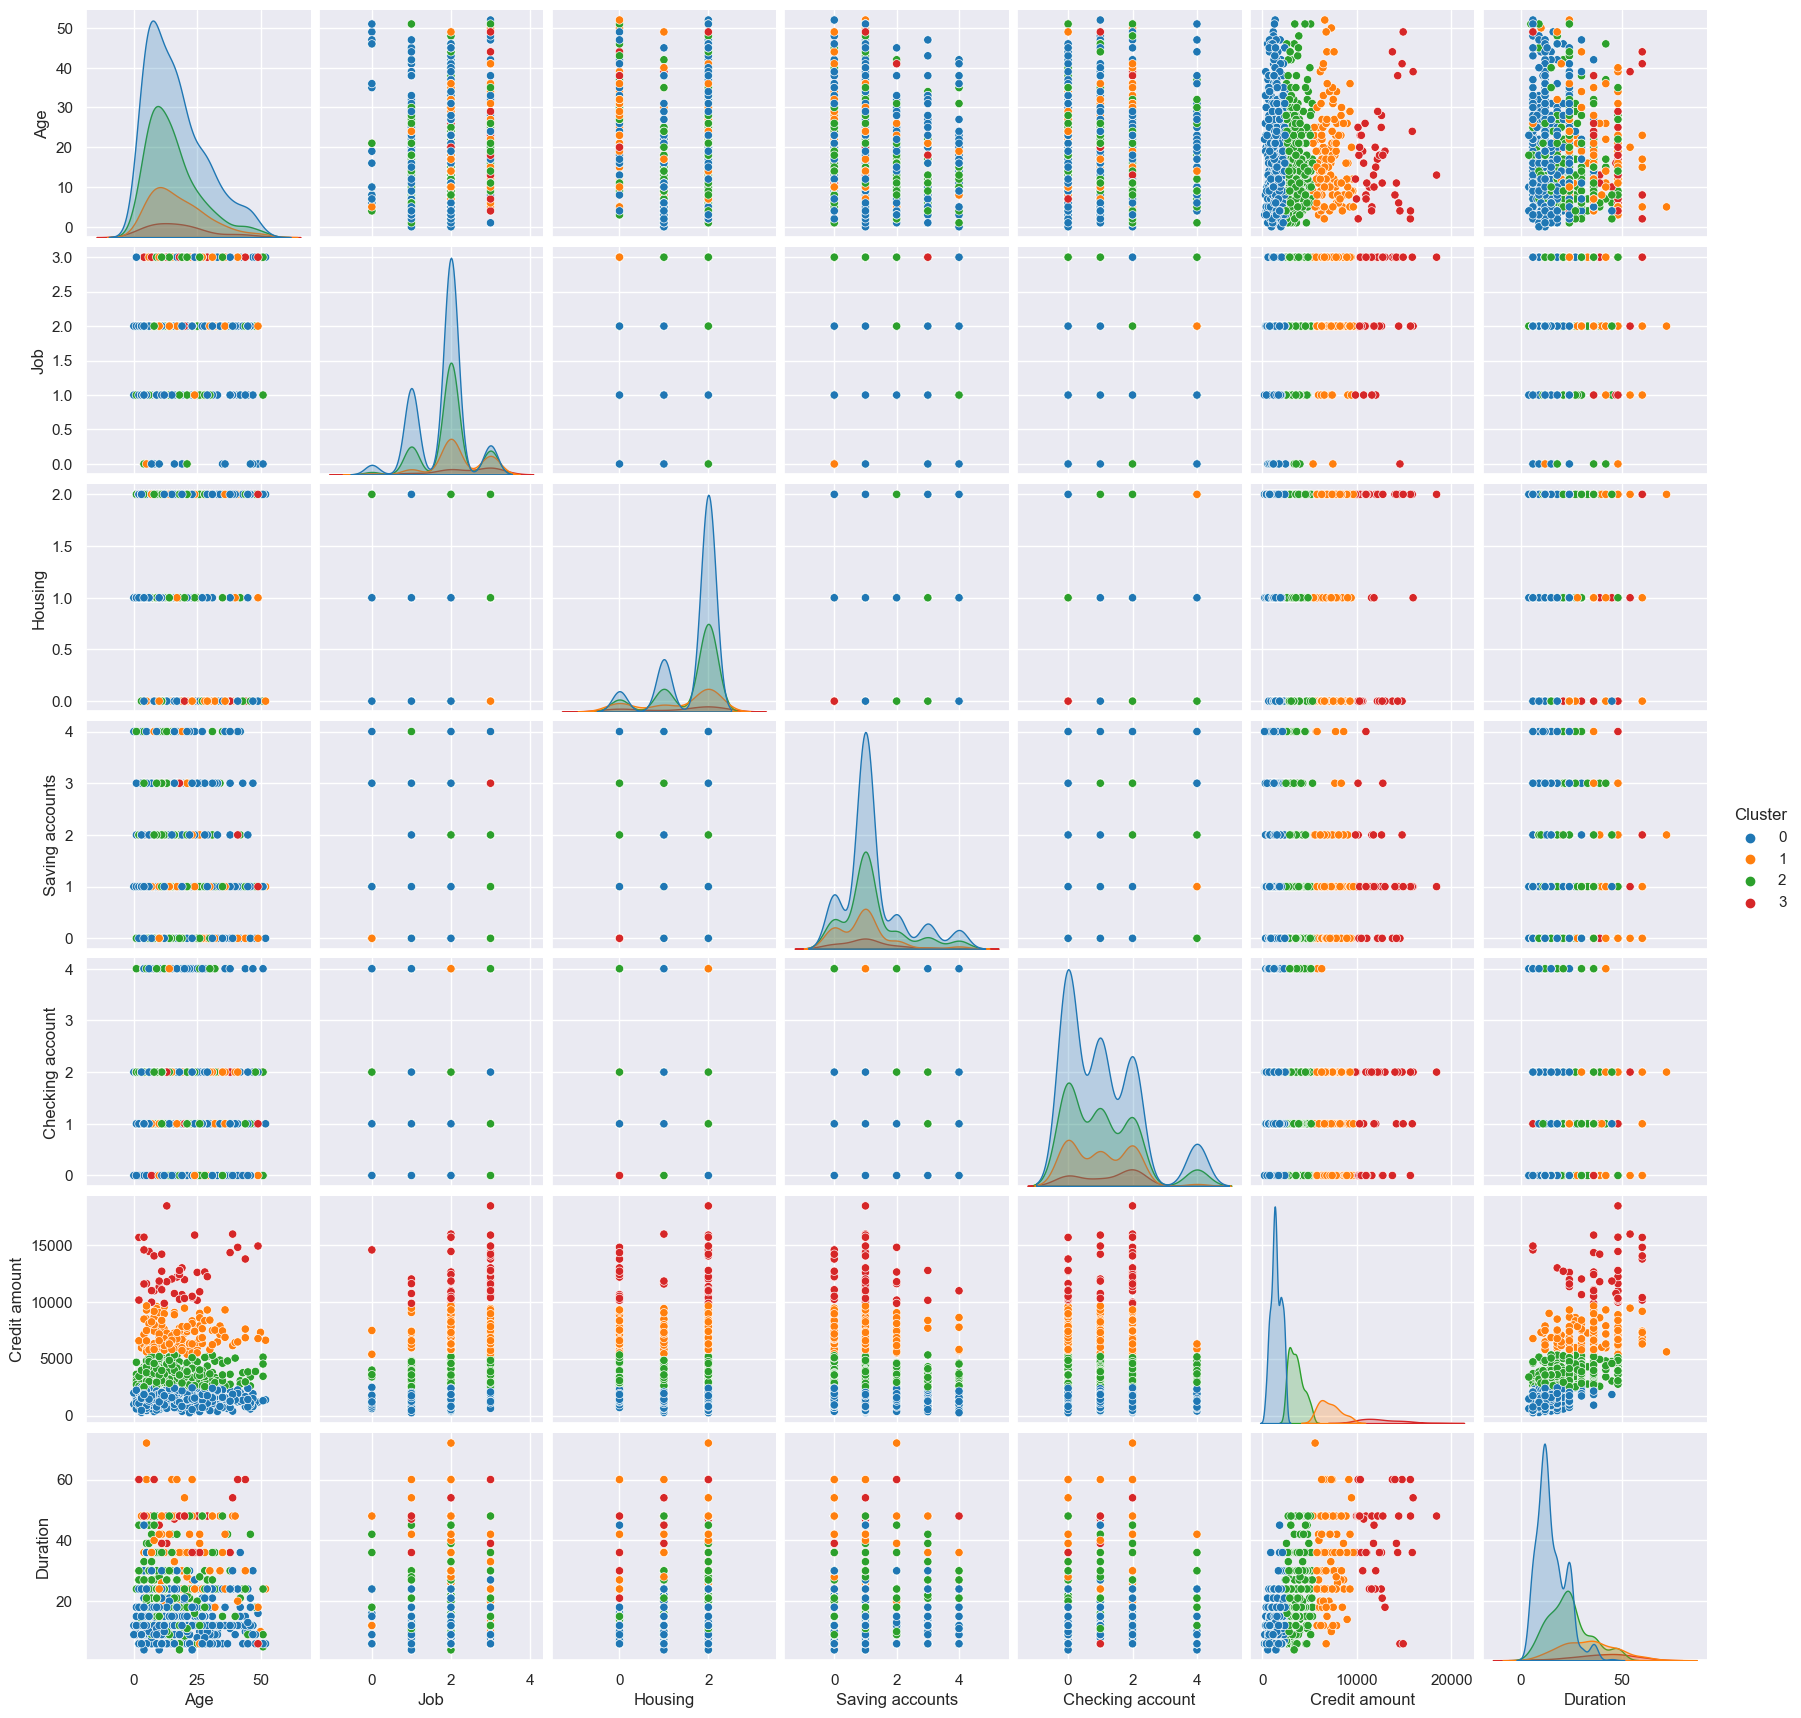

In [46]:
df_clustered = cdf[['Age', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration']]
df_clustered["Cluster"] = clusters

# Adjust the height parameter as needed
sns.pairplot(df_clustered, hue="Cluster", palette='tab10', height=2.5)

# Show the plot
plt.show()

### K-Nearest Neighbors Classification

In [47]:
# Spliting X and y into train and test version
X, y = df.drop("Risk", axis=1), df["Risk"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=0)

In [48]:
max_score = 0
max_k = 0
for k in range(1, 100):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train,y_train)
    score = f1_score(y_test, neigh.predict(X_test))
    if score > max_score:
        max_k = k
        max_score = score
print("If use K-Nearest Neighbors Classification, the k should be " + str(max_k) + " to get best prediction, and then the  mean accuracy is " + str(max_score))

If use K-Nearest Neighbors Classification, the k should be 69 to get best prediction, and then the  mean accuracy is 0.8352941176470587


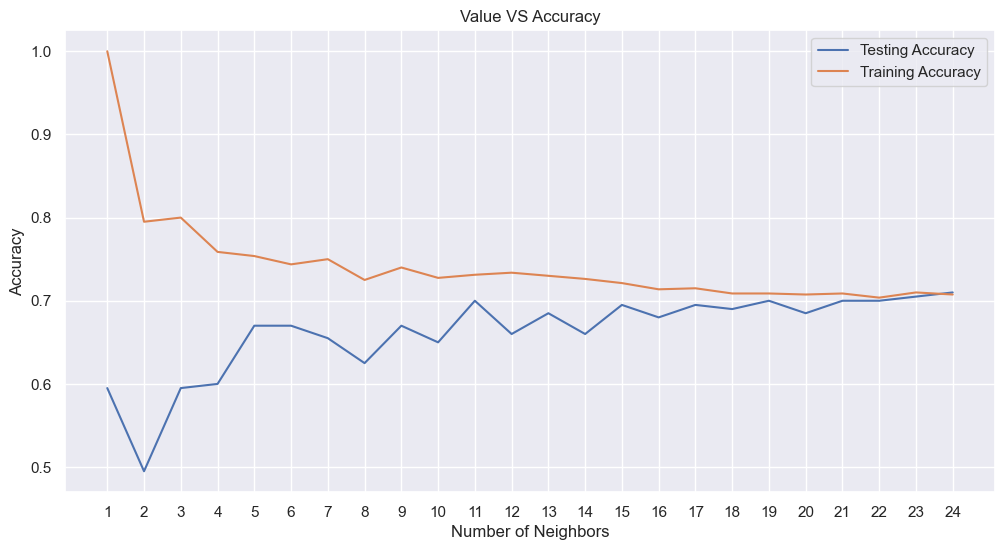

Best accuracy is 0.71 with K = 24


In [49]:
neig = np.arange(1, 25)
train_accuracy = []
test_accuracy = []
# Loop over different values of k
for i, k in enumerate(neig):
    # k from 1 to 25(exclude)
    knn_model = KNeighborsClassifier(n_neighbors=k)
    # Fit with knn
    knn_model.fit(X_train,y_train)
    #train accuracy
    train_accuracy.append(knn_model.score(X_train, y_train))
    # test accuracy
    test_accuracy.append(knn_model.score(X_test, y_test))

# Plot
plt.figure(figsize=[12,6])
plt.plot(neig, test_accuracy, label = 'Testing Accuracy')
plt.plot(neig, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.title('Value VS Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.xticks(neig)
plt.show()
print("Best accuracy is {} with K = {}".format(np.max(test_accuracy),1+test_accuracy.index(np.max(test_accuracy))))

### Modeling by Other Classifiers
Since KNN algorithm cost lots of memory and time for prediction, this section want to try some more classifiers.
#### Model Selection with Cross Validate

In [50]:
# define models
Models = {
    "SVC": SVC(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "GaussianNaiveBayes": GaussianNB(),
   
}


In [55]:
cv_results = pd.DataFrame(columns=['model', 'train_score', 'test_score', 'fit_time', 'score_time'])
for key in Models.keys():
    cv_res = model_selection.cross_validate(Models[key], X_train, y_train, 
                                             return_train_score=True,
                                             scoring="f1",
                                             cv=5, n_jobs=-1)
    res = {
        'model': key, 
        'train_score': cv_res["train_score"].mean(), 
        'test_score': cv_res["test_score"].mean(),
        'fit_time': cv_res["fit_time"].mean(),
        'score_time': cv_res["score_time"].mean()
        }
    cv_results = cv_results._append(res, ignore_index=True)
    print("CV for model:", key, "done.")
cv_results.style.background_gradient(cmap='Blues')



CV for model: SVC done.
CV for model: DecisionTree done.
CV for model: RandomForest done.
CV for model: GaussianNaiveBayes done.


,model,train_score,test_score,fit_time,score_time
0,SVC,0.825890,0.826072,0.045922,0.020066
1,DecisionTree,1.000000,0.748736,0.014402,0.006113
2,RandomForest,1.000000,0.827640,0.505553,0.025852
3,GaussianNaiveBayes,0.811976,0.810961,0.005804,0.006405


Evaluate Model on Testing Set

* Random Forest Classifier gives a good result on both train_score and test_score.
* SVC and Gaussian Naive Bayes show the less over-fiting.
* Gaussian Naive Bayes Classifier has least runtime.

Random Forest Classifier would tell feature importances, while SVC only return coef_ in the case of a linear kernel, which will be too slow.

In [56]:
rf = Models["RandomForest"].fit(X_train, y_train)
print('f1_score:', f1_score(y_test, rf.predict(X_test)))

f1_score: 0.8514851485148515


In [57]:
from sklearn.svm import SVC
feature_importance = pd.DataFrame()
feature_importance["feature"] = X_train.columns
feature_importance["importance"] = rf.feature_importances_
feature_importance = feature_importance.sort_values("importance", ascending=False)
feature_importance

,feature,importance
7,Credit amount,0.199675
0,Unnamed: 0,0.171009
8,Duration,0.142697
1,Age,0.140593
6,Checking account,0.119472
9,Purpose,0.069156
5,Saving accounts,0.053580
3,Job,0.042995
4,Housing,0.036817
2,Sex,0.024005


## Conclusion
1. Machine Learning based models are very pragmatic when it comes to minimizing the risk. Increasing number of banks are choosing such models for their risk analysis and to minimize the loss by preventing defaults. There are a multitude of Machine Learning techniques for the purpose of predicting the real values, classification, clustering etc. We only scratched the surface with our case. However, certain things should considered when applying Machine Learning techniques:

1. The model itself should explain the result. If an algorithm denies a loan of an applicant, it is important for the bank to know the explanation. Otherwise they could even face legal obligations from the applicant. Therefore, it is sometimes reasonable to use relatively simple models (like logistic regression, Gradient boosted trees, Random Forest as in our case) instead of complicated models like Neural Networks.
1. Recently Apple’s credit card has been accused of discriminating against women. Models can be socially prejudiced as they take insights from the historical data. In our case too, the model predicted that the females are more likely to default. This is because, we have performed a Discrete-Time hazard model where the probability of default is a point-in-time event. A good model however should incorporate the evolution of the impacts of the features on the risk over a period. These kinds of models are called Through-the-cycle (TTC) models, which consider the influence of the macroeconomic situation, social evolution and other factors.